# Titanic - Machine Learning from Disaster [Kaggle Competition]

The biggest reason that led to the loss of life was that there were not enough lifeboats for the passengers and crew. There was definitely some luck invoolved in surviving and sinking, we are going to analyze what sorts of people were more likely to survive. 

Using machine learning, we will predict which passengers survived the shipwreck.

Dataset: https://www.kaggle.com/c/titanic/data

### Understanding the Problem

- When the Titanic sank, 1502 / 2224 passenger and crew were killed. This gives the wreck a 32% survival rate.
- Some people were more likely than others to survive, such as women, children, and the upper-class.

In [4]:
# For Data Analysis
import pandas as pd
import numpy as np
import random as rnd

# For Visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# For Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Reading the Data

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]

In [6]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


#### Describing the Data

**Which features are categorical?**
Categorical features have values that are nominal, ordinal, ratio, or interval based. 
For example: 
- The blood type of a person
- The state that a person lives in
- Type of rock

In this case, the categorical features are: Survived, Sex, and Embarked. Ordinal: Pclass

**Which features are numerical?**
These values are discrete, continuous, or timeseries based. 
In this case, the numerical features are: Fare. Discrete: SibSp, Parch.
- SibSp: # of siblings / spouses aboard the Titanic. 
- Parch: # of parents / children aboard the Titanic

In [7]:
# View the Data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features have mixed data types?**

Let's see which features have numerican and sphanumerical data mixed. 
- Ticket is a mixture of numerican and alphanumerical. Cabin is alphanumeric.

**Which features may have typos or errors?**
This one is harder to tell but we can make a guess for which feature is likely to have typos or errors. 
- The name feature may contain errors or typos as there are many different ways to describe a name (titles, round brackets, quotes, etc)

**Which features contain blank, null, or empty values?**
We will have to clean this.
- Cabin, Age, Embarked fatures contained a number of null values in the training dataset.

**What are the data types for various features?**
- 7 features are intergers or floats.
- 5 features are strings (object)

In [9]:
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

#### We can get some insight from the samples

- Total samples are 891 or 40% of the actual passengers aboard the Titanic (891/2,224)
- Survived has categorical values of 0 and 1
- Around 38% of samples survived compared to the actual survival rate of 32%
- More than 75% of passengers did not travel with parents or children (Parch)
- Nearly 30% of the passengers had siblings and/or spouse on board (SibSp)
- Fares varied significantly with less than 1% of the passengers paying as high as $512

In [10]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### The distribution of categorical features
- Names are unique across the dataset
- 577 males VS 314 female. 65% male on board
- Many people shared a cabin, so there are several duplicates
- There are 3 different values for Embarked. Most people used the S (Southampton) port
- 22% of the tickets had duplicate ticket prices

In [11]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Allum, Mr. Owen George",male,1601,G6,S
freq,1,577,7,4,644


#### Assumptions based on the analysis

**Correlation**
- We can to see which feature correlates the most with Survival.

**Completing**
- Age and Embarkment are definitely correlated to survival, so, we need to complete them.

**Correcting**
- We can drop the Ticket feature because 22% of them are duplicates (too high). 
- We can also drop Cabin because it is highly incomplete or contained many null values.
- PassengerId can be dropped because it doesn't correlate to Survival
- Name can also be dropped because it probably doesn't have any relation to Survival

**Creating**
- We can craete a new feature called Family based on Parch and SibSp to get total count of family members on board
- We may want to extract the person's Title from their Name and create a new feature
- Perhaps turn the Age feature from a numberical feature to an ordinal categorical feature
- We may also want to create a Fare range feature to see if it helps our analysis

**Classifying**
We can add the following to our assumptions:
- Sex=female are more likely to have survived
- Children were more likely to have survived
- Pclass=1 were more likely to have survived

### Compare Features Against Each Other
We can analyze the correlations of the features against each other. At the moment, some of our features have empty values, so we can only use features with non-empty values. We will only be doing this for features which are categorical(Sex), ordinal(Pclass), or discrete (SibSp, Parch) type.
- Discrete: The data are said to be discrete if the measurements are integers
- Ordinal: if an ordering exists (ticket class, socio-economic status)
________________________________________________________________________________
- **Pclass**: We can see a significant correlation (>0.5) between Pclass=1 and Survived.
- **Sex**: We can see that when Sex=female, the survival rate is ~74%
- **SibSp and Parch**: These features do not really have a specific correlation to survival. It may be best for us to dervie a new feature from these individual features

In [12]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [14]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Visualiza the Data
We can analyze the data by visualizing it.
___
#### Plotting a correlation matrix

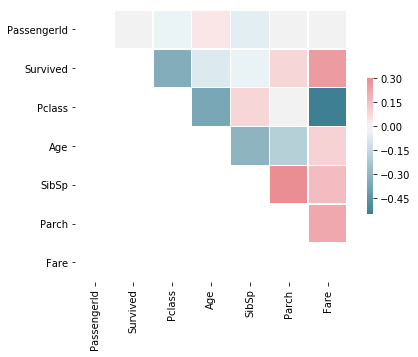

In [16]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Numerical Features Correlation
Let's visualize the correlation between our numerical features and Survived.
We can use a histogram because it is helpful when analyzing continuous numerical variables such as Age.

**Observations**
- Infants (Age <= 4) had a high rate of survival
- Oldest passenges (Age = 80) survived
- Large number of 15-25 year olds did not survive
- Most passengers are in the 15-35 age range

**What this says about our assumptions**
- We should consider Age in our model training
- We should complete the Age feature for null values
- We should group the age ranges

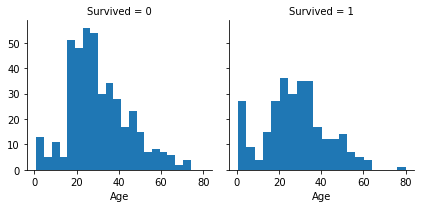

In [17]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#### Correlating numerical and ordinal features
We can visualize the numerical and categorical features which has numeric values.

**Observations**
- Pclass =3 had the most passengers, however, most did not survive. Confirms our assumption.
- Infant passengers in Pclass = 2 and Pclass = 3 mostly survived. Confirms our assumption about children.
- Most passengers in Pclass = 1 survived. Confirms our assumption about high-class passengers.
- Pclass varies in terms of age distribution 

**Decisions**
- Consider Pclass when training the model

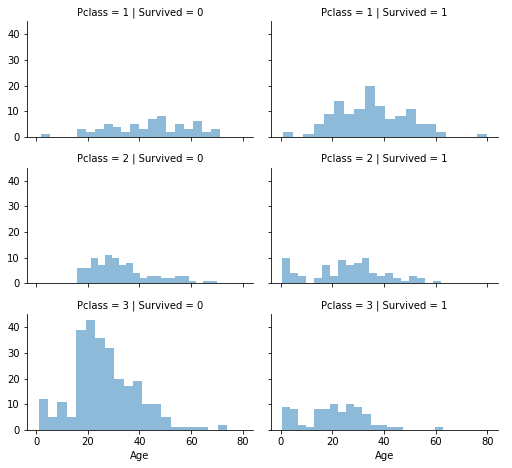

In [18]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

#### Correlatig Categorical Features

**Observations** 
- Female passengers had a much better survival rate than males.
- Exception in Embarked = C, where males had a higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and survived, not necessarily in Embarked and Survived.
- Males had a better rate of survival in Pclass = 3 when compared with Pclass = 2 for C and Q ports.
- Ports of embarking have varying survival rates for Pclass = 3 and among male passengers. 

**Decisions** 
- Add the Sex feature when training the model
- Complete and add Embarked feature to model training

c:\users\simran\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\simran\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\simran\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


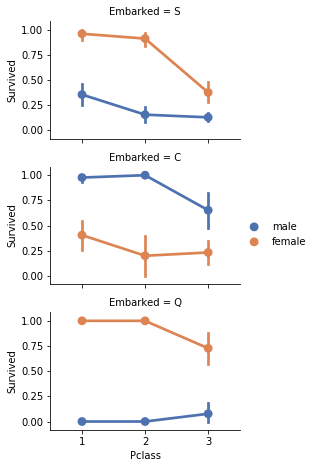

In [19]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correcting Categorical and Numerical Features
We can also consider correlating Embarked (Categorical, Non-numerical), Sex (Categorical, Non-numerical), Fare (Numeric continuous), with Survived (Categorical numberical).

**Observations** 
- Higher fare paying passengers had a better rate of survival. Means we should group fare ranges.
- Port of embarking correlates with survival rates. We should complete this feature.

**Decisions**
- Considering grouping fare-ranges

c:\users\simran\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


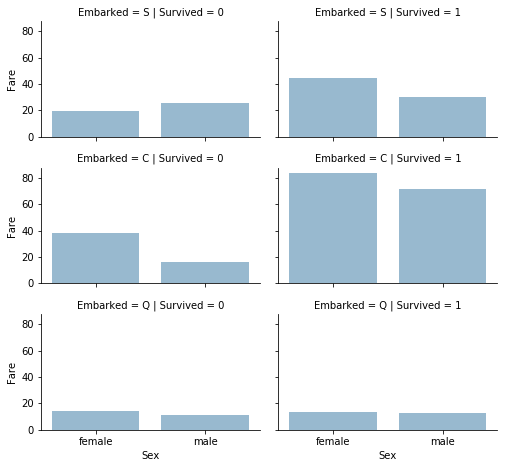

In [20]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height = 2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Correct, Create, and Complete the Data
Now that we have figured out assumptions and come up with what to do, we can correct, create, and complete the data that we talked about earlier.

#### Correcting by dropping features
By droping features, we are dealing with fewer data points, meaning our model will not have to deal with useless information.

Based on our decisions, we can drop Cabin and Ticket features.

We have to perform these features on the training and testing datasets to stay consistent.

In [21]:
print('Before:', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print('\nAfter', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before: (891, 12) (418, 11) (891, 12) (418, 11)

After (891, 10) (418, 9) (891, 10) (418, 9)


### Creating New Feature from Existing
Before we drop Name and PassengerId features, we want to see if the Name feature can be engineered to extract titles and test the correlation between titles and survival.

We will extract the Title feature using regular expressions. The RegEx pattern (\w\.) matches the first word which ends with a dot character within Name feature. The `expand=False` flag returns a DataFrame.

**Observations**
- Most titles band Age groups accurately. For example, Master title has age mean of 5 years
- Survival among Title Age bands varies slightly
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer)

**Decision**
- We can keep the Title feature for model training

In [22]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


There are a lot of titles that are not common. We can replace these with `Rare`

In [23]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal

In [24]:
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


We can now drop the Name feature because we already extracted the title from it. We can drop the PassengerId feature as well.

In [25]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
print(combine[0].shape, combine[1].shape)

(891, 9) (418, 9)


#### Converting Categorical Feature
We can convert features that have strings into numerical values. Features need to be numerical values for most models to work. 
Let's convert the Sex feature to a new feature called Sex where female = 1  and male = 0

In [26]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Let's band together some of the Age groups and determine the correlation with Survived

In [27]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


Now we can replace the Age feature with numerical values based on these bands.

In [28]:
for dataset in combine:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1.0,1,0,7.2500,S,1,"(16.336, 32.252]"
1,1,1,1,2.0,1,0,71.2833,C,3,"(32.252, 48.168]"
2,1,3,1,1.0,0,0,7.9250,S,2,"(16.336, 32.252]"
3,1,1,1,2.0,1,0,53.1000,S,3,"(32.252, 48.168]"
4,0,3,0,2.0,0,0,8.0500,S,1,"(32.252, 48.168]"


We can now drop the `AgeBand` feature

In [29]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1.0,1,0,7.2500,S,1
1,1,1,1,2.0,1,0,71.2833,C,3
2,1,3,1,1.0,0,0,7.9250,S,2
3,1,1,1,2.0,1,0,53.1000,S,3
4,0,3,0,2.0,0,0,8.0500,S,1


#### Create a new feature combining existing features
We can create a new feature called FamilySize which combined Parch and SibSp. This will enable us to drop Parch and SibSp.

In [30]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


#### We can create another feature called IsAlone

In [31]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


We can drop Parch, SibSp, and FamilySize features in favour of IsAlone

In [32]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

combine = [train_df, test_df]    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1.0,7.2500,S,1,0
1,1,1,1,2.0,71.2833,C,3,0
2,1,3,1,1.0,7.9250,S,2,1
3,1,1,1,2.0,53.1000,S,3,0
4,0,3,0,2.0,8.0500,S,1,1
5,0,3,0,NaN,8.4583,Q,1,1
6,0,1,0,3.0,51.8625,S,1,1
7,0,3,0,0.0,21.0750,S,4,0
8,1,3,1,1.0,11.1333,S,3,0
9,1,2,1,0.0,30.0708,C,3,0


We have some missing values for Age. So, let's fill them with the mean of the ages and round it to the closest int.

In [33]:
train_df['Age'].fillna((train_df['Age'].mean()).astype(int), inplace=True)
test_df['Age'].fillna((test_df['Age'].mean()).astype(int), inplace=True)
combine = [train_df, test_df]
print(combine[0].head(10))

   Survived  Pclass  Sex  Age     Fare Embarked  Title  IsAlone
0         0       3    0  1.0   7.2500        S      1        0
1         1       1    1  2.0  71.2833        C      3        0
2         1       3    1  1.0   7.9250        S      2        1
3         1       1    1  2.0  53.1000        S      3        0
4         0       3    0  2.0   8.0500        S      1        1
5         0       3    0  2.0   8.4583        Q      1        1
6         0       1    0  3.0  51.8625        S      1        1
7         0       3    0  0.0  21.0750        S      4        0
8         1       3    1  1.0  11.1333        S      3        0
9         1       2    1  0.0  30.0708        C      3        0


Let's create an artificial feature combining Pclass and Age.

In [34]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,6.0,2.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


### Completing a Categorical feature
Embarked also has some missing values. We cam fill these with the most common occurance.

In [35]:
freq_port = train_df.Embarked.dropna().mode()[0]
print(freq_port)

S


In [36]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Convert Categorical Feature into Numerical
Let's convert the Embarked feature  by creating a new feature called Port, which will hold numeric values.

In [37]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1.0,7.2500,0,1,0,3.0
1,1,1,1,2.0,71.2833,1,3,0,2.0
2,1,3,1,1.0,7.9250,0,2,1,3.0
3,1,1,1,2.0,53.1000,0,3,0,2.0
4,0,3,0,2.0,8.0500,0,1,1,6.0


### Completing and Converting a Numeric Feature
Let's complete the Fare feature for a single missing value in the test dataset using mode to get teh value taht occurs most frequently for this feature. 

In [38]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2.0,7.8292,2,1,1,6.0
1,893,3,1,2.0,7.0000,0,3,0,6.0
2,894,2,0,3.0,9.6875,2,1,1,6.0
3,895,3,0,1.0,8.6625,0,1,1,3.0
4,896,3,1,1.0,12.2875,0,3,0,3.0


Let's create a new feature called FareBand where we will group fare ranges.

In [39]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand. Once we do this, we can drop the FareBand feature.

In [40]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1.0,0,0,1,0,3.0
1,1,1,1,2.0,3,1,3,0,2.0
2,1,3,1,1.0,1,0,2,1,3.0
3,1,1,1,2.0,3,0,3,0,2.0
4,0,3,0,2.0,1,0,1,1,6.0
5,0,3,0,2.0,1,2,1,1,6.0
6,0,1,0,3.0,3,0,1,1,3.0
7,0,3,0,0.0,2,0,4,0,0.0
8,1,3,1,1.0,1,0,3,0,3.0
9,1,2,1,0.0,2,1,3,0,0.0


In [41]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2.0,0,2,1,1,6.0
1,893,3,1,2.0,0,0,3,0,6.0
2,894,2,0,3.0,1,2,1,1,6.0
3,895,3,0,1.0,1,0,1,1,3.0
4,896,3,1,1.0,1,0,3,0,3.0
5,897,3,0,0.0,1,0,1,1,0.0
6,898,3,1,1.0,0,2,2,1,3.0
7,899,2,0,1.0,2,0,1,0,2.0
8,900,3,1,1.0,0,1,3,1,3.0
9,901,3,0,1.0,2,0,1,0,3.0


### Let's create our model, predict, and solve

Our data is ready to be used in training a model and predict the outcome. One of the biggest questions is which predictive modelling algorithm to use out of the 60+. Our problem is a classification and regression problem. Our goal is to identify the relationship between output (Survived or not) with the other variables or features (Sex, Age, Embarked, etc). We are also performing a category of machine learning which is called supervised learning as we are trianing our model with a given dataset. Given this criteria, Super Learning plus Classification and Regression, we can narrow down the model we can use to the following few:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Naive Bayes Classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial Neural Network
- Relevance Vector Machine (RVM)

In [42]:
X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
print(X_train.shape, Y_train.shape, X_test.shape)

(891, 8) (891,) (418, 8)


#### Let's do another correlation matrix to see the realtionships between features

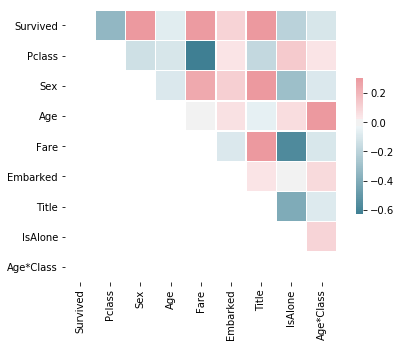

In [43]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Logistic Regression is a useful and quite straight forward model to run early in the workflow. It measures the relationship between the categorical dependent variables (feature) and one or more independent variables (features) by estimating probabilities using logistic function, which is a cumulative logistic distribution.
____
#### Logistic Regression

In [44]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, Y_train)
Y_pred = log_reg.predict(X_test)
acc_log = round(log_reg.score(X_train, Y_train) * 100, 2)

print(acc_log)

80.02


We can use Logistic Regression to validate our assumptions and decisions for future creating and completing goals. This can be done by calculating the coefficient of the features in the decision functions. 

Positive coefficients increase the log-odds of the response and thus increase the probability. Negative coefficients decrease the log-odds of the response and thus decrease the probability. 
- Sex is the highest positive coeficient, implying as the Sex values increases (male: 0, female: 1), the probability of Survived=1 increases the most
- Inversely, as the Pclass increases, the chance of Survived = 1 decreases the most
- The way Age*Class is a good artificial feature to model as it has the second highest negative correlation with Survived
- Title has the second higher positive correlation

In [45]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(log_reg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.196194
5,Title,0.387412
4,Embarked,0.368870
2,Age,0.209926
6,IsAlone,0.123357
3,Fare,-0.076632
7,Age*Class,-0.233912
0,Pclass,-0.748273


#### Support Vector Machines (SVM)
SVM's are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)

In [46]:
svc = SVC(gamma='auto')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

print(acc_svc)

83.95


#### k-Nearest Neighbors (KNN)

In pattern recognition, the k-Nearest Neighbors algorithm (KNN) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k=1, then the object is simply assigned to the class of that single nearest neighbor. [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

In [47]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

print(acc_knn)

84.85


#### Naive Bayes Classifier
In Machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

In [48]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

print(acc_gaussian)

72.84


#### The Perceptron

This is an algorithm for supervised learning of binary classifiers (function that can decide whether an input, represented by a vector of number, belonds to some specific class or not). It is not a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. THe algorithm allows for online learning, in that it processes elements in the training set one at a time. [Wikipedia](https://en.wikipedia.org/wiki/Perceptron)

In [49]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

print(acc_perceptron)

73.06


C:\Users\Simran\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


#### Linear SVC

In [50]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

C:\Users\Simran\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


79.46

#### Stochastic Gradient Descent

In [51]:
stochastic_gd = SGDClassifier()
stochastic_gd.fit(X_train, Y_train)
Y_pred = stochastic_gd.predict(X_test)
acc_sgd = round(stochastic_gd.score(X_train, Y_train) * 100, 2)
acc_sgd

C:\Users\Simran\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


39.39

#### Decision Tree

The decision tree is a predictive model which maps features (tree branches) to conclusions about the target value (tree values). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning)

In [52]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

87.43

#### Random Forests

Random Forests is one of the most popular models. Random Forests or random decision forests are an ensemble learning method for claaification, regression, and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. [Wikipedia](https://en.wikipedia.org/wiki/Random_forest)

In [53]:
random_forests = RandomForestClassifier(n_estimators=100)
random_forests.fit(X_train, Y_train)
Y_pred = random_forests.predict(X_test)
random_forests.score(X_train, Y_train)
acc_random_forests = round(random_forests.score(X_train, Y_train) * 100, 2)
acc_random_forests

87.43

#### Evaluating the Models

The Decision Tree and Random Forests score is the exact same, so, we can see which one works better. Decision Tree's have a habit of overfitting to the training set that they have been given, so we will go with the Random Forests. 

In [54]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
             'Random Forest', 'Naive Bayes', 'Perceptron', 
             'Stochastic Gradient Descent', 'Linear SVS',
             'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log,
             acc_random_forests, acc_gaussian, acc_perceptron,
             acc_sgd, acc_linear_svc, acc_decision_tree]})

models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,87.43
8,Decision Tree,87.43
1,KNN,84.85
0,Support Vector Machines,83.95
2,Logistic Regression,80.02
7,Linear SVS,79.46
5,Perceptron,73.06
4,Naive Bayes,72.84
6,Stochastic Gradient Descent,39.39


In [56]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)